In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from multiprocessing import Pool
from sklearn.utils import class_weight
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdmnb
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OneHotEncoder ,StandardScaler,LabelEncoder
import torch
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

!pip install pandarallel
from pandarallel import pandarallel as pl
pl.initialize(progress_bar=True, verbose=0)

# Loading the example data

In [58]:
def processor_fn(n):
    return pd.read_csv(f'/kaggle/input/nfl-big-data-bowl-2023/week{n}.csv')

In [59]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        if 'week5' in filename:
            weeks = os.path.join(dirname, filename)
        if 'players' in filename:
            players = os.path.join(dirname, filename)
        if 'pffScoutingData' in filename:
            pffScoutingData = os.path.join(dirname, filename)
        if 'plays' in filename:
            plays = os.path.join(dirname, filename)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

pffScoutingData_df = pd.read_csv(pffScoutingData)
#pffScoutingData_df.head()
plays = pd.read_csv(plays)
#plays.head()
player_df = pd.read_csv(players)
#player_df.head()
'''使用單個week'''
#tracking_df =  pd.read_csv(weeks)
#tracking_df
'''使用多個week'''
START_WEEK = 2
END_WEEK = 5  # non-inclusive
weeks = list(range(START_WEEK, END_WEEK))
weeks_data = []
pool = Pool(processes=4)

for df in tqdmnb(pool.imap(processor_fn, iterable=weeks), total=len(weeks)):
    weeks_data.append(df)
tracking_df = pd.concat(weeks_data, ignore_index=True)
#tracking_df

/kaggle/input/nfl-big-data-bowl-2023/players.csv
/kaggle/input/nfl-big-data-bowl-2023/week6.csv
/kaggle/input/nfl-big-data-bowl-2023/week2.csv
/kaggle/input/nfl-big-data-bowl-2023/pffScoutingData.csv
/kaggle/input/nfl-big-data-bowl-2023/week3.csv
/kaggle/input/nfl-big-data-bowl-2023/week8.csv
/kaggle/input/nfl-big-data-bowl-2023/games.csv
/kaggle/input/nfl-big-data-bowl-2023/week5.csv
/kaggle/input/nfl-big-data-bowl-2023/week7.csv
/kaggle/input/nfl-big-data-bowl-2023/week1.csv
/kaggle/input/nfl-big-data-bowl-2023/week4.csv
/kaggle/input/nfl-big-data-bowl-2023/plays.csv


  0%|          | 0/3 [00:00<?, ?it/s]

In [60]:
gp_df = tracking_df[['gameId', 'playId']].drop_duplicates()
gp_df.reset_index(drop=True, inplace=True)
gp_df

,gameId,playId
0,2021091600,65
1,2021091600,111
2,2021091600,187
3,2021091600,235
4,2021091600,261
...,...,...
3316,2021100400,3859
3317,2021100400,4096
3318,2021100400,4118
3319,2021100400,4139


In [61]:
tracking_df['event'].unique()

array(['None', 'ball_snap', 'play_action', 'pass_forward',
       'autoevent_passforward', 'qb_sack', 'run', 'autoevent_ballsnap',
       'autoevent_passinterrupted', 'pass_arrived', 'pass_outcome_caught',
       'shift', 'man_in_motion', 'pass_tipped', 'qb_strip_sack',
       'penalty_flag', 'line_set', 'huddle_break_offense',
       'first_contact', 'pass_outcome_incomplete', 'handoff', 'fumble',
       'fumble_offense_recovered', 'tackle', 'dropped_pass'], dtype=object)

In [62]:
tracking_df[(tracking_df['playId']== 4401) & (tracking_df['team']== 'football')]

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event


In [63]:
tracking_df[(tracking_df['playId']== 4401) & (tracking_df['team']== 'BAL')& (tracking_df['nflId']== 38557.0)]

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event


# PreProcess Data

In [64]:
def get_position_counts(row,trackingDf):
    expr = (trackingDf['gameId'] == row['gameId']) & (trackingDf['playId'] == row['playId'])
    df = trackingDf.loc[expr]
    # The number of positions involved in the play should be the same for every frame
    # in the play, so only count the number of positions in the first frame.
    vc = df.loc[df['frameId'] == 1, 'officialPosition'].value_counts()
    return pd.DataFrame(np.array([vc.values]), columns=vc.keys())

In [65]:
'''用left join的方式將球員資料對應到tracking data'''
playerMapping_to_tracking = pd.merge(tracking_df,player_df, how='left', on='nflId')

In [66]:
'''將tracking data 中的缺失值填補'''
playerMapping_to_tracking['officialPosition']=playerMapping_to_tracking['officialPosition'].fillna('ball')
playerMapping_to_tracking['o']=playerMapping_to_tracking['o'].fillna(0)
playerMapping_to_tracking['dir']=playerMapping_to_tracking['dir'].fillna(0)
playerMapping_to_tracking['weight']=playerMapping_to_tracking['weight'].fillna(0)

# 身高處理
playerMapping_to_tracking['height'] = playerMapping_to_tracking['height'].fillna("0")
heightSplit = playerMapping_to_tracking['height'].str.split("-", expand = True)
playerMapping_to_tracking['height_feet'] = heightSplit[0] + "." + heightSplit[1]
playerMapping_to_tracking['height_feet'] = playerMapping_to_tracking['height_feet'].fillna("0")
playerMapping_to_tracking['height_feet'] = playerMapping_to_tracking['height_feet'].astype(float)

tracking_df = playerMapping_to_tracking
tracking_df

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,...,o,dir,event,height,weight,birthDate,collegeName,officialPosition,displayName,height_feet
0,2021091600,65,40031.0,1,2021-09-17T00:23:09.600,23.0,NYG,right,46.32,22.36,...,271.71,79.32,None,5-11,195.0,1991-02-09,Rutgers,FS,Logan Ryan,5.11
1,2021091600,65,40031.0,2,2021-09-17T00:23:09.700,23.0,NYG,right,46.43,22.39,...,275.92,72.33,None,5-11,195.0,1991-02-09,Rutgers,FS,Logan Ryan,5.11
2,2021091600,65,40031.0,3,2021-09-17T00:23:09.800,23.0,NYG,right,46.54,22.44,...,278.85,67.03,None,5-11,195.0,1991-02-09,Rutgers,FS,Logan Ryan,5.11
3,2021091600,65,40031.0,4,2021-09-17T00:23:09.900,23.0,NYG,right,46.65,22.49,...,282.45,62.63,None,5-11,195.0,1991-02-09,Rutgers,FS,Logan Ryan,5.11
4,2021091600,65,40031.0,5,2021-09-17T00:23:10.000,23.0,NYG,right,46.77,22.56,...,285.54,59.26,None,5-11,195.0,1991-02-09,Rutgers,FS,Logan Ryan,5.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3239200,2021100400,4161,NaN,46,2021-10-05T03:45:55.200,NaN,football,right,20.03,20.49,...,0.00,0.00,autoevent_passforward,0,0.0,NaN,NaN,ball,NaN,0.00
3239201,2021100400,4161,NaN,47,2021-10-05T03:45:55.300,NaN,football,right,20.54,20.01,...,0.00,0.00,None,0,0.0,NaN,NaN,ball,NaN,0.00
3239202,2021100400,4161,NaN,48,2021-10-05T03:45:55.400,NaN,football,right,25.33,16.50,...,0.00,0.00,None,0,0.0,NaN,NaN,ball,NaN,0.00
3239203,2021100400,4161,NaN,49,2021-10-05T03:45:55.500,NaN,football,right,27.40,14.92,...,0.00,0.00,None,0,0.0,NaN,NaN,ball,NaN,0.00


In [67]:
def normalize_x(row, show_pbar=True):
    if show_pbar:
        pbar.update(1)
    if row['playDirection'] == 'left':
        return 120.0 - row['x']
    else:
        return row['x']

def normalize_y(row, show_pbar=True):
    if show_pbar:
        pbar.update(1)
    if row['playDirection'] == 'left':
        return 160/3 - row['y']
    else:
        return row['y']
    
pbar = tqdm(range(len(tracking_df)*2))
tracking_df['x_norm'] = tracking_df[['x', 'playDirection']].apply(normalize_x, axis=1)
tracking_df['y_norm'] = tracking_df[['y', 'playDirection']].apply(normalize_y, axis=1)
del pbar
tracking_df

100%|██████████| 6478410/6478410 [01:34<00:00, 68429.48it/s]


,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,...,event,height,weight,birthDate,collegeName,officialPosition,displayName,height_feet,x_norm,y_norm
0,2021091600,65,40031.0,1,2021-09-17T00:23:09.600,23.0,NYG,right,46.32,22.36,...,None,5-11,195.0,1991-02-09,Rutgers,FS,Logan Ryan,5.11,46.32,22.36
1,2021091600,65,40031.0,2,2021-09-17T00:23:09.700,23.0,NYG,right,46.43,22.39,...,None,5-11,195.0,1991-02-09,Rutgers,FS,Logan Ryan,5.11,46.43,22.39
2,2021091600,65,40031.0,3,2021-09-17T00:23:09.800,23.0,NYG,right,46.54,22.44,...,None,5-11,195.0,1991-02-09,Rutgers,FS,Logan Ryan,5.11,46.54,22.44
3,2021091600,65,40031.0,4,2021-09-17T00:23:09.900,23.0,NYG,right,46.65,22.49,...,None,5-11,195.0,1991-02-09,Rutgers,FS,Logan Ryan,5.11,46.65,22.49
4,2021091600,65,40031.0,5,2021-09-17T00:23:10.000,23.0,NYG,right,46.77,22.56,...,None,5-11,195.0,1991-02-09,Rutgers,FS,Logan Ryan,5.11,46.77,22.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3239200,2021100400,4161,NaN,46,2021-10-05T03:45:55.200,NaN,football,right,20.03,20.49,...,autoevent_passforward,0,0.0,NaN,NaN,ball,NaN,0.00,20.03,20.49
3239201,2021100400,4161,NaN,47,2021-10-05T03:45:55.300,NaN,football,right,20.54,20.01,...,None,0,0.0,NaN,NaN,ball,NaN,0.00,20.54,20.01
3239202,2021100400,4161,NaN,48,2021-10-05T03:45:55.400,NaN,football,right,25.33,16.50,...,None,0,0.0,NaN,NaN,ball,NaN,0.00,25.33,16.50
3239203,2021100400,4161,NaN,49,2021-10-05T03:45:55.500,NaN,football,right,27.40,14.92,...,None,0,0.0,NaN,NaN,ball,NaN,0.00,27.40,14.92


In [68]:
tracking_df.columns

Index(['gameId', 'playId', 'nflId', 'frameId', 'time', 'jerseyNumber', 'team',
       'playDirection', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'event',
       'height', 'weight', 'birthDate', 'collegeName', 'officialPosition',
       'displayName', 'height_feet', 'x_norm', 'y_norm'],
      dtype='object')

## 取得位置的資訊

In [69]:
pos_counts = gp_df.parallel_apply(get_position_counts, axis=1 , trackingDf = tracking_df)
pos_counts_max = pd.concat([df for df in pos_counts]).max().astype(int)
del pos_counts  # Mark temp object for deletion to free memory
pos_counts_max.head()

WR     5
CB     5
T      4
G      3
ILB    3
dtype: int64

In [70]:
pos_counts_max.keys()

Index(['WR', 'CB', 'T', 'G', 'ILB', 'OLB', 'FS', 'TE', 'DT', 'QB', 'NT', 'SS',
       'C', 'RB', 'ball', 'DE', 'MLB', 'FB', 'LB'],
      dtype='object')

## 依據play id 將各個位置的frameId資料整合 當作一個Sequence

In [71]:
padding_data = [[0.0] * (11)] * 2
padding_data

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

In [72]:
def format_features(row,tracking_data_source_df=None, all_positions=None ,feature_cols=None,pos_counts_max=None ):
    '''調整frame長度，固定為64'''
    needed_frame_len = range(1,65)
    #print(f'row:{row}')
    filter = (tracking_data_source_df['gameId'] == row['gameId']) \
             & (tracking_data_source_df['playId'] == row['playId'])
    '''取得進攻與防守隊伍'''
    defensiveOroffensive_expr = (plays['gameId'] ==  row['gameId']) & (plays['playId'] == row['playId'])
    #print(f'defensiveOroffensive_expr')
    defensiveOroffensive_df = plays.loc[defensiveOroffensive_expr]
    #print(f'defensiveOroffensive_df index:{defensiveOroffensive_df.index[0]}')
    possessionTeam= defensiveOroffensive_df.loc[defensiveOroffensive_df.index[0]].at['possessionTeam']
    #print(f'possessionTeam:{possessionTeam}')
    defensiveTeam = defensiveOroffensive_df.loc[defensiveOroffensive_df.index[0]].at['defensiveTeam']
    #print(f'defensiveTeam:{defensiveTeam}')
    ''' 取出相對應的play資料'''
    play_df = tracking_data_source_df.loc[filter]
    '''整理進攻Team與防守Team資訊'''
    #print(f'整理進攻與防守資訊')
    play_df['offenseTeam'] = play_df.apply(lambda r :  1 if r['team']==possessionTeam else 0 , axis = 1)
    play_df['defensiveTeam'] = play_df.apply(lambda r :  1 if r['team']==defensiveTeam else 0 , axis = 1)
    play_df['ballTeam'] = play_df.apply(lambda r :  1 if r['team']=='football' else 0 , axis = 1)
    #print(play_df.head())
    #print(f'整理進攻與防守資訊 END')
    '''取得frames的集合並排序'''
    frames = sorted(play_df['frameId'].unique())
    #print(f'frames:{frames}')
    
    frame_data = [] #容器用以裝入處理好的frame data
    
    '''存放最後的frame的freture資料'''
    last_features =np.nan
    '''  Iterate through every frame in the play'''
    #print(f'Iterate start')
    for fid in needed_frame_len:
        '''檢查frame的長度 如果不夠就將最後的feature資料補上'''
        if fid in frames:
            #print(f'fid:{fid}')
            features = np.array([])
            offenseTeam = np.array([]) #容器用以裝入 進攻隊伍frame data
            defensiveTeam = np.array([]) #容器用以裝入 防守隊伍frame data
            ballTeam  = np.array([])  #容器用以裝入 球frame data
            '''Iterate每個位置，不一定在play每個位置都會有''' 
            for pos in all_positions:
                
                #print(f'pos:{pos}')
                pos_data = play_df.loc[(play_df['frameId'] == fid) &
                                   (play_df['officialPosition'] == pos),
                                   feature_cols].values
                '''長度為0代表沒有這個位置的資料需要跳過'''   
                pos_data_len = len(pos_data)
                if pos_data_len != 0:                        
                    pos_data =np.nan_to_num(np.hstack(pos_data))
                    features = np.hstack((features, pos_data))           
                    
                diff = pos_counts_max[pos] - pos_data_len 
                #print(f'diff 長度:{(diff)}')
                if diff > 0:
                    padding_data = [[0.0] * (len(feature_cols) )] * diff
                    #print(f'padding_data:{padding_data}')
                    
                    #print(f'len(padding_data):{len(padding_data)}')
                    if len(padding_data) != 0:
                        padding_data = np.hstack((padding_data))
                        features = np.hstack((features, padding_data))
            # 檢查features 長度
            
            flen =len(features)
            #print(f'features 長度:{flen}')
            if int(flen) != 504 :
                print(f'features 長度:{flen}')
                raise ExampleError("長度Error")
                
            #print(f'features len:{flen}')
            last_features = features.copy()
            #print(f'last_features len:{len(last_features)}')
            frame_data.append(features) 
            
         #break 
        else:
            '''小於64都用最後的feature填滿'''
            frame_data.append(last_features)
    #print(f' return frame_data')
    return frame_data

'''取的傳球結果'''
def get_pass_results(row , plays_df):
    
    return plays_df.loc[(plays_df['gameId'] == row['gameId']) &
                        (plays_df['playId'] == row['playId']),
                        'passResult'].values[0]

'''取得每個play的frame長度'''
def get_frame_len(row,tracking_df):
    filter = (tracking_df['gameId'] == row['gameId']) &(tracking_df['playId'] == row['playId'])
    frame_len=tracking_df[filter]
    return len(frame_len['frameId'].unique())

'''取得每個play處理過的frame長度'''
def get_Processed_frame_len(row):
    sequence_len =len(row['features'])
    return sequence_len

def get_player_indicies(df, play_outcomes):
    # Only gather data between the ball snap and pass outcome
    start_idx = df['event'].eq('ball_snap').idxmax()
    end_idx = df['event'].isin(play_outcomes).idxmax()
    # idxmax() gets the index of the first occurance, so subtract one
    # from the index to keep the time series samples the same length
    end_idx = end_idx - 1 if end_idx else len(df)
    return start_idx, end_idx

In [73]:
#gp_df
# These are the column names to use as feature data.
feature_label_df = gp_df.copy()
feature_label_df['labels'] = feature_label_df.parallel_apply(get_pass_results, axis=1 , plays_df=plays)
feature_label_df['frame_len'] = feature_label_df.parallel_apply(get_frame_len, axis=1 , tracking_df=tracking_df)
'''取frame 長度 64以下的'''
feature_label_df = feature_label_df[feature_label_df['frame_len'] <=64]
feature_label_df = feature_label_df[feature_label_df['labels'] !='R']
feature_label_df

,gameId,playId,labels,frame_len
0,2021091600,65,I,38
1,2021091600,111,S,64
2,2021091600,187,C,35
4,2021091600,261,S,49
5,2021091600,280,C,44
...,...,...,...,...
3314,2021100400,3805,I,53
3316,2021100400,3859,IN,46
3317,2021100400,4096,I,39
3319,2021100400,4139,I,47


In [74]:
''' 處理Sequence Features'''
play_outcomes = ['pass_outcome_caught', 'pass_outcome_incomplete', 'pass_outcome_interception',
                 'pass_outcome_touchdown', 'qb_sack', 'qb_strip_sack', 'touchdown']
feature_cols = ['x_norm', 'y_norm', 's', 'a', 'dis', 'o', 'dir', 'height_feet', 'weight']
all_positions = sorted(pos_counts_max.keys())
feature_label_df['features']= feature_label_df.parallel_apply(format_features, axis=1, args=[ tracking_df,all_positions,feature_cols,pos_counts_max])
feature_label_df

,gameId,playId,labels,frame_len,features
0,2021091600,65,I,38,"[[32.2, 29.78, 0.0, 0.0, 0.0, 70.55, 136.21, 6..."
1,2021091600,111,S,64,"[[39.69, 23.83, 0.0, 0.0, 0.0, 76.5, 237.35, 6..."
2,2021091600,187,C,35,"[[35.36, 23.873333333333335, 0.0, 0.0, 0.0, 27..."
4,2021091600,261,S,49,"[[65.68, 23.853333333333335, 0.0, 0.0, 0.01, 2..."
5,2021091600,280,C,44,"[[64.06, 23.763333333333335, 0.0, 0.0, 0.0, 25..."
...,...,...,...,...,...
3314,2021100400,3805,I,53,"[[46.48, 23.65, 0.03, 0.03, 0.01, 72.78, 241.2..."
3316,2021100400,3859,IN,46,"[[62.54, 23.61, 0.0, 0.0, 0.0, 78.63, 284.5, 6..."
3317,2021100400,4096,I,39,"[[19.33, 26.51, 0.0, 0.0, 0.0, 81.03, 34.37, 6..."
3319,2021100400,4139,I,47,"[[22.1, 26.29, 0.0, 0.0, 0.01, 76.65, 279.21, ..."


In [75]:
'''在取得處理後的frame 長度 ,得知真實長度'''
feature_label_df['processed_frame_len']= feature_label_df.parallel_apply(get_Processed_frame_len, axis=1)
feature_label_df

,gameId,playId,labels,frame_len,features,processed_frame_len
0,2021091600,65,I,38,"[[32.2, 29.78, 0.0, 0.0, 0.0, 70.55, 136.21, 6...",64
1,2021091600,111,S,64,"[[39.69, 23.83, 0.0, 0.0, 0.0, 76.5, 237.35, 6...",64
2,2021091600,187,C,35,"[[35.36, 23.873333333333335, 0.0, 0.0, 0.0, 27...",64
4,2021091600,261,S,49,"[[65.68, 23.853333333333335, 0.0, 0.0, 0.01, 2...",64
5,2021091600,280,C,44,"[[64.06, 23.763333333333335, 0.0, 0.0, 0.0, 25...",64
...,...,...,...,...,...,...
3314,2021100400,3805,I,53,"[[46.48, 23.65, 0.03, 0.03, 0.01, 72.78, 241.2...",64
3316,2021100400,3859,IN,46,"[[62.54, 23.61, 0.0, 0.0, 0.0, 78.63, 284.5, 6...",64
3317,2021100400,4096,I,39,"[[19.33, 26.51, 0.0, 0.0, 0.0, 81.03, 34.37, 6...",64
3319,2021100400,4139,I,47,"[[22.1, 26.29, 0.0, 0.0, 0.01, 76.65, 279.21, ...",64


In [76]:
'''手動驗證(大概的驗證一下)'''
sequence_len =len(feature_label_df['features'][0])
print(f'sequence_len :{sequence_len}')
feature62_len =len(feature_label_df['features'][0][62])
print(f'feature62_len :{feature62_len}')
feature63_len =len(feature_label_df['features'][0][63])
print(f'feature63_len :{feature63_len}')

print(feature_label_df['features'][0][62])
#print(feature_label_df['features'][0][63])

sequence_len :64
feature62_len :504
feature63_len :504
[2.6570e+01 3.5830e+01 3.1900e+00 1.9700e+00 3.3000e-01 2.3756e+02
 2.7644e+02 6.4000e+00 3.1200e+02 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 5.0530e+01 1.0290e+01 7.3200e+00 9.2000e-01 7.3000e-01 1.1621e+02
 1.0021e+02 6.1000e+00 2.1200e+02 5.0930e+01 4.3230e+01 5.5000e+00
 3.6300e+00 5.5000e-01 1.8099e+02 1.0552e+02 5.1100e+00 1.8500e+02
 3.9680e+01 2.2650e+01 3.9000e+00 4.4100e+00 3.8000e-01 3.0746e+02
 7.8070e+01 5.1000e+00 1.9800e+02 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000

## 產出資料

In [77]:
'''最終產出'''
feature_label_df

,gameId,playId,labels,frame_len,features,processed_frame_len
0,2021091600,65,I,38,"[[32.2, 29.78, 0.0, 0.0, 0.0, 70.55, 136.21, 6...",64
1,2021091600,111,S,64,"[[39.69, 23.83, 0.0, 0.0, 0.0, 76.5, 237.35, 6...",64
2,2021091600,187,C,35,"[[35.36, 23.873333333333335, 0.0, 0.0, 0.0, 27...",64
4,2021091600,261,S,49,"[[65.68, 23.853333333333335, 0.0, 0.0, 0.01, 2...",64
5,2021091600,280,C,44,"[[64.06, 23.763333333333335, 0.0, 0.0, 0.0, 25...",64
...,...,...,...,...,...,...
3314,2021100400,3805,I,53,"[[46.48, 23.65, 0.03, 0.03, 0.01, 72.78, 241.2...",64
3316,2021100400,3859,IN,46,"[[62.54, 23.61, 0.0, 0.0, 0.0, 78.63, 284.5, 6...",64
3317,2021100400,4096,I,39,"[[19.33, 26.51, 0.0, 0.0, 0.0, 81.03, 34.37, 6...",64
3319,2021100400,4139,I,47,"[[22.1, 26.29, 0.0, 0.0, 0.01, 76.65, 279.21, ...",64


In [78]:
#針對前處理的資料先排除label == R
feature_label_df = feature_label_df.drop(feature_label_df[feature_label_df.labels == 'R'].index)

#labels one hot encoding 
category_one_hot = {'C': [1.0, 0.0, 0.0, 0.0],'I': [0.0, 1.0, 0.0, 0.0],
                    'S': [0.0, 0.0, 1.0, 0.0],'IN': [0.0, 0.0, 0.0, 1.0]}
categories = feature_label_df['labels'].apply(lambda lbl: category_one_hot[lbl])
labels_input = np.stack(categories)

#features
features_input = np.stack(feature_label_df['features'])

In [79]:
from sklearn.model_selection import train_test_split
#切分訓練集(驗證集)、測試集
train_x, test_x, train_y, test_y = train_test_split(features_input, labels_input, test_size = 0.1)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.23)

# The Model

In [80]:
from sklearn.utils.class_weight import compute_class_weight
y_integers =np.argmax(train_y ,axis =1)
y_integers

array([1, 0, 1, ..., 1, 0, 1])

In [81]:
class_weights = compute_class_weight(class_weight='balanced', classes = np.unique(y_integers),y = y_integers)
d_class_weight =dict(enumerate(class_weights))

In [82]:
d_class_weight

{0: 0.4262634631317316,
 1: 0.7555066079295154,
 2: 4.149193548387097,
 3: 11.184782608695652}

In [83]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.losses import CategoricalCrossentropy
from keras.metrics import AUC

In [250]:
frameNum = 64    #每一play的frame數量
featureNum = 504 #(每對11個選手 * 2 + 1 (ball)) * 11 特徵

model = Sequential()
model.add(LSTM(100, return_sequences = False ,input_shape = (frameNum,featureNum)))
# model.add(LSTM(50, return_sequences=True))
# model.add(LSTM(50))
model.add(Dense(4)) #針對權重bias_regularizer
model.add(Activation('softmax'))
model.compile(loss = CategoricalCrossentropy(label_smoothing = 0.993),
              optimizer = 'adam', metrics = [AUC()])
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 100)               242000    
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 404       
_________________________________________________________________
activation_18 (Activation)   (None, 4)                 0         
Total params: 242,404
Trainable params: 242,404
Non-trainable params: 0
_________________________________________________________________


In [251]:
import matplotlib.pyplot as plt

# Trainging 
EPOCHS = 8
BATCH_SIZE = 128
history = model.fit(train_x, train_y,
                    validation_data = (val_x, val_y),
                    epochs = EPOCHS, batch_size = BATCH_SIZE )

Epoch 1/8
17/17 [==============================] - 6s 200ms/step - loss: 1.4364 - auc_18: 0.4816 - val_loss: 1.4001 - val_auc_18: 0.4250
Epoch 2/8
17/17 [==============================] - 3s 193ms/step - loss: 1.3949 - auc_18: 0.5309 - val_loss: 1.3913 - val_auc_18: 0.5127
Epoch 3/8
17/17 [==============================] - 3s 163ms/step - loss: 1.3901 - auc_18: 0.4587 - val_loss: 1.3888 - val_auc_18: 0.5199
Epoch 4/8
17/17 [==============================] - 3s 161ms/step - loss: 1.3883 - auc_18: 0.5315 - val_loss: 1.3877 - val_auc_18: 0.5509
Epoch 5/8
17/17 [==============================] - 3s 160ms/step - loss: 1.3874 - auc_18: 0.5451 - val_loss: 1.3872 - val_auc_18: 0.5320
Epoch 6/8
17/17 [==============================] - 3s 153ms/step - loss: 1.3870 - auc_18: 0.5641 - val_loss: 1.3870 - val_auc_18: 0.6073
Epoch 7/8
17/17 [==============================] - 3s 168ms/step - loss: 1.3868 - auc_18: 0.5814 - val_loss: 1.3869 - val_auc_18: 0.6058
Epoch 8/8
17/17 [========================

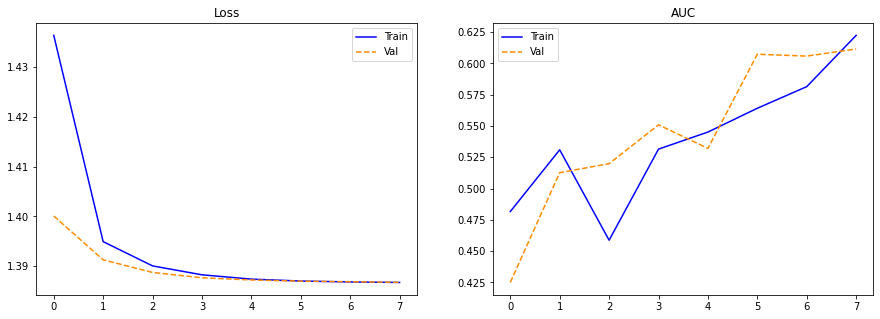

In [252]:
# Plot the loss and accuracy
fig = plt.figure(figsize=(15, 5)) #設定圖形大小

#左邊Loss圖
loss_plot = fig.add_subplot(1,2,1)
loss_plot.plot(history.history['loss'], color='blue', label='Train')
loss_plot.plot(history.history['val_loss'], color='darkorange', linestyle='dashed', label='Val')

loss_plot.title.set_text('Loss')
loss_plot.legend()

#右邊AUC
auc_plot = fig.add_subplot(1, 2, 2)

auc_hist = next(v for k, v in history.history.items() if k.startswith('auc')) #e.g.,auc_1 找aux前綴
auc_plot.plot(auc_hist, color='blue', label='Train')
val_auc_hist = next(v for k, v in history.history.items() if k.startswith('val_auc'))
auc_plot.plot(val_auc_hist, color='darkorange', linestyle='dashed', label='Val')

auc_plot.title.set_text('AUC')
auc_plot.legend()

In [253]:
# 用測試集評估模型
score = model.evaluate(test_x, test_y, verbose = 2)
print('Loss:', score[0])
print('AUC:' , score[1])

10/10 - 0s - loss: 1.3868 - auc_18: 0.6152
Loss: 1.3867738246917725
AUC: 0.6152107119560242


## Training metrics


[[116  42  11   8]
 [ 56  26   5   3]
 [ 14   4   1   0]
 [  7   4   1   0]]


Text(51.0, 0.5, 'Actual')

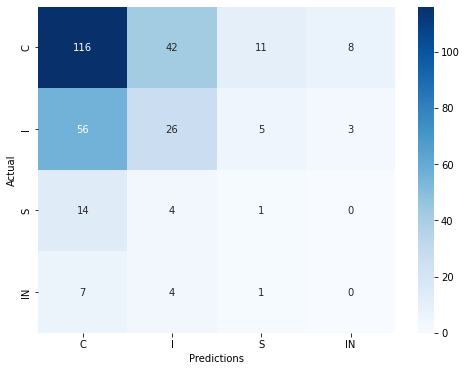

In [254]:
# Display the confusion matrix
import seaborn as sbn
from sklearn.metrics import confusion_matrix

pred_y = model.predict(test_x)
predictions = pred_y.argmax(axis=1)
actual = test_y.argmax(axis=1)
cm = confusion_matrix(actual, predictions)
print(cm)
plt.figure(figsize=(8, 6))
ax = plt.subplot()
sbn.heatmap(cm, annot=True, fmt='d', ax=ax,
            xticklabels=category_one_hot.keys(),
            yticklabels=category_one_hot.keys(),
            cmap='Blues')
ax.set_xlabel('Predictions')
ax.set_ylabel('Actual')

In [255]:
# View the classification report.
from sklearn.metrics import classification_report

print(classification_report(actual, predictions, target_names=category_one_hot.keys()))

              precision    recall  f1-score   support

           C       0.60      0.66      0.63       177
           I       0.34      0.29      0.31        90
           S       0.06      0.05      0.05        19
          IN       0.00      0.00      0.00        12

    accuracy                           0.48       298
   macro avg       0.25      0.25      0.25       298
weighted avg       0.46      0.48      0.47       298



## Trace Animate

In [256]:
import pandas as pd
import numpy as np
import os
#import seaborn as sns
#from ipywidgets import interact, fixed
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from matplotlib.animation import FFMpegWriter

from datetime import datetime
import dateutil
from math import radians
from IPython.display import Video
import warnings
warnings.filterwarnings('ignore')

def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=55,
                          highlight_first_down_line=False,
                          yards_to_go=10,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        #plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
        #         color='yellow')
        
    if highlight_first_down_line:
        fl = hl + yards_to_go
        plt.plot([fl, fl], [0, 53.3], color='yellow')
        #plt.text(fl + 2, 50, '<- {}'.format(highlighted_name),
        #         color='yellow')
    return fig, ax

def calculate_dx_dy_arrow(x, y, angle, speed, multiplier):
    if angle <= 90:
        angle = angle
        dx = np.sin(radians(angle)) * multiplier * speed
        dy = np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    if angle > 90 and angle <= 180:
        angle = angle - 90
        dx = np.sin(radians(angle)) * multiplier * speed
        dy = -np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    if angle > 180 and angle <= 270:
        angle = angle - 180
        dx = -(np.sin(radians(angle)) * multiplier * speed)
        dy = -(np.cos(radians(angle)) * multiplier * speed)
        return dx, dy
    if angle > 270 and angle <= 360:
        angle = 360 - angle
        dx = -np.sin(radians(angle)) * multiplier * speed
        dy = np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    
        
def animate_player_movement(weekNumber, playId, gameId):
    path = '/kaggle/input/nfl-big-data-bowl-2023/'

    weekData = pd.read_csv(path + 'week' + str(weekNumber) + '.csv')
    playData = pd.read_csv(path + 'plays.csv')
    gameData = pd.read_csv(path + 'games.csv')
    game = gameData.loc[gameData['gameId'] == gameId]
    team_home = game['homeTeamAbbr'].iloc[0]
    team_visit = game['visitorTeamAbbr'].iloc[0]
    
    playHome = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "' + str(team_home) + '"')
    playAway = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "' + str(team_visit) + '"')
    playFootball = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "football"')
    
    playHome['time'] = playHome['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playAway['time'] = playAway['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playFootball['time'] = playFootball['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    # Need to replace NaN in the 'position' column with 'ball' to match the training data.
    #playFootball['position'].fillna('ball', inplace=True)

    maxTime = int(playAway['time'].unique().max())
    minTime = int(playAway['time'].unique().min())
    
    yardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardlineNumber'].item()
    yardsToGo = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardsToGo'].item()
    absoluteYardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['absoluteYardlineNumber'].item() - 10
    playDir = playHome.sample(1)['playDirection'].item()
    
    if (absoluteYardlineNumber > 50):
        yardlineNumber = 100 - yardlineNumber
    if (absoluteYardlineNumber <= 50):
        yardlineNumber = yardlineNumber
        
    if (playDir == 'left'):
        yardsToGo = -yardsToGo
    else:
        yardsToGo = yardsToGo
    
    fig, ax = create_football_field(highlight_line=True, highlight_line_number=yardlineNumber, highlight_first_down_line=True, yards_to_go=yardsToGo)
    playDesc = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['playDescription'].item()
    plt.title(f'Game # {gameId} Play # {playId} \n {playDesc}')
    
    def update_animation(time):
        patch = []
        
        homeX = playHome.query('time == ' + str(time))['x']
        homeY = playHome.query('time == ' + str(time))['y']
        homeNum = playHome.query('time == ' + str(time))['jerseyNumber']
        homeOrient = playHome.query('time == ' + str(time))['o']
        homeDir = playHome.query('time == ' + str(time))['dir']
        homeSpeed = playHome.query('time == ' + str(time))['s']
        patch.extend(plt.plot(homeX, homeY, 'o',c='gold', ms=20, mec='white'))
        
        # Home players' jersey number 
        for x, y, num in zip(homeX, homeY, homeNum):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='black', size='medium'))
            
        # Home players' orientation
        for x, y, orient in zip(homeX, homeY, homeOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='gold', width=0.5, shape='full'))
            
        # Home players' direction
        for x, y, direction, speed in zip(homeX, homeY, homeDir, homeSpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='black', width=0.25, shape='full'))
        
        # Home players' location
        awayX = playAway.query('time == ' + str(time))['x']
        awayY = playAway.query('time == ' + str(time))['y']
        awayNum = playAway.query('time == ' + str(time))['jerseyNumber']
        awayOrient = playAway.query('time == ' + str(time))['o']
        awayDir = playAway.query('time == ' + str(time))['dir']
        awaySpeed = playAway.query('time == ' + str(time))['s']
        patch.extend(plt.plot(awayX, awayY, 'o',c='orangered', ms=20, mec='white'))
        
        # Away players' jersey number 
        for x, y, num in zip(awayX, awayY, awayNum):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='white', size='medium'))
            
        # Away players' orientation
        for x, y, orient in zip(awayX, awayY, awayOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='orangered', width=0.5, shape='full'))
        
        # Away players' direction
        for x, y, direction, speed in zip(awayX, awayY, awayDir, awaySpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='black', width=0.25, shape='full'))
        
        # Away players' location
        footballX = playFootball.query('time == ' + str(time))['x']
        footballY = playFootball.query('time == ' + str(time))['y']
        patch.extend(plt.plot(footballX, footballY, 'o', c='black', ms=10, mec='white', data=playFootball.query('time == ' + str(time))['team']))
        
        # Display the pass outcome prediction in the title area
        features_df = pd.concat([playHome.loc[playHome['time'] <= time],
                                 playAway.loc[playAway['time'] <= time],
                                 playFootball.loc[playFootball['time'] <= time]])
        #prediction = get_prediction(features_df)
        #patch.append(plt.text(40, 55, f'Pass prediction: {prediction}', ha='left', color='red', size='x-large', weight='bold'))
        
        return patch
    
    ims = [[]]
    for time in tqdm(np.arange(minTime, maxTime+1)):
    #    for time in [minTime, minTime+1, minTime+2]:
        patch = update_animation(time)
        ims.append(patch)
        
    anim = animation.ArtistAnimation(fig, ims, repeat=False)
    
    return anim

## get animate video

100%|██████████| 38/38 [00:02<00:00, 13.99it/s]


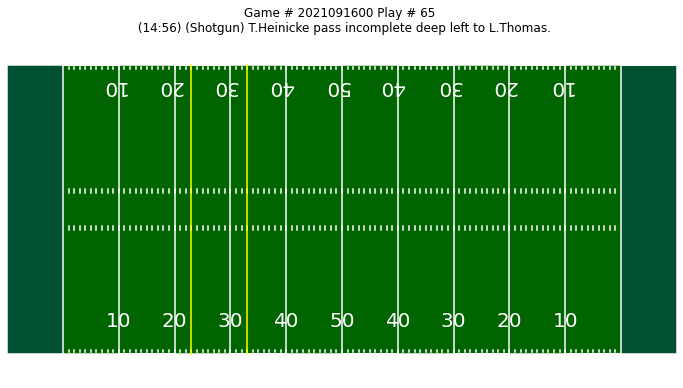

In [257]:
# video create
gameID = 2021091600
playID = 65
weekNum = 2
video = animate_player_movement(weekNum,playID,gameID)
video.save('/kaggle/working/video.mp4')